Iteration 0/3000...


C:\Users\Hi\AppData\Local\Temp\ipykernel_10708\2223276719.py:147: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(p_value)


Iteration 300/3000...
Iteration 600/3000...
Iteration 900/3000...
Iteration 1200/3000...
Iteration 1500/3000...
Iteration 1800/3000...
Iteration 2100/3000...
Iteration 2400/3000...
Iteration 2700/3000...
Finished simulations.


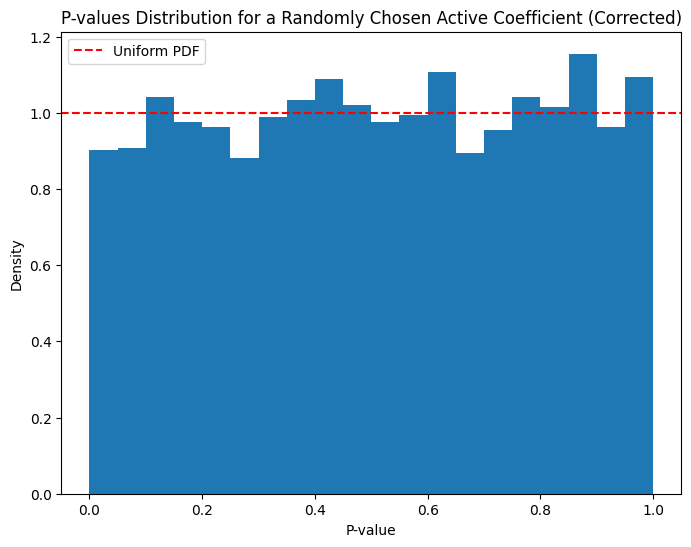

Kolmogorov-Smirnov test for uniformity:
KS Statistic: 0.0196
P-value: 0.1965


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, t, kstest
from sklearn.linear_model import Lasso 
import statsmodels.api as sm
import random
import time


np.random.seed(0)
random.seed(0)
n = 500
p = 10
iters = 3000
lam = 0.1
true_beta = np.zeros(p)  
std_noise = 10
X = np.random.normal(0, 1, size=(n, p))


def create_data(X, true_beta, intercept=0, std_noise=1):
    n = X.shape[0]
    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size=n)
    y = linear_component + noise + intercept
    return y

def soft_thresholding(rho, lam, z):
    if rho < -lam:
        return (rho + lam) / z
    elif rho > lam:
        return (rho - lam) / z
    else:
        return 0

def fit_lasso_model_corrected(X, y, lam, max_iter=7000, tol=1e-5):
    """
    Fits a Lasso model using Coordinate Descent algorithm with intercept.
    """
    n, p = X.shape
    beta = np.zeros(p)
    intercept = np.mean(y)

    for iter_num in range(max_iter):
        beta_old = beta.copy()
        intercept_old = intercept

        intercept = np.mean(y - X @ beta)

        for j in range(p):
            partial_residual_j = y - (X @ beta - X[:, j] * beta[j]) - intercept
            rho_j = np.dot(X[:, j], partial_residual_j) / n
            z_j = np.sum(X[:, j]**2) / n
            beta[j] = soft_thresholding(rho_j, lam, z_j)

        if (np.linalg.norm(beta - beta_old, ord=1) < tol and
            abs(intercept - intercept_old) < tol):
            break
            
    beta[np.abs(beta) < tol] = 0.0

    return beta, intercept

def f(mu, sigma, a, b, x):
    if sigma <= 1e-9:
        return np.nan
    
    denom = norm.cdf(b, loc=mu, scale=sigma) - norm.cdf(a, loc=mu, scale=sigma)
    if denom <= 1e-9:
        return np.nan
    
    cdf_at_x = (norm.cdf(x, loc=mu, scale=sigma) - norm.cdf(a, loc=mu, scale=sigma)) / denom
    p_value = 2 * min(cdf_at_x, 1 - cdf_at_x)
    return p_value

def calculating_p_value(X, active_set, y, beta_hat, intercept, std_noise, lam):
    # This function now assumes X and y are centered, and intercept is ~0.
    n, p = X.shape
    if len(active_set) == 0:
        return np.nan 
    
    X_active = X[:, active_set]
    beta_hat_active = beta_hat[active_set]
    p_active = len(active_set)
    s = np.sign(beta_hat_active)

    choice = random.randint(0, p_active - 1)
    e_j = np.zeros(p_active)
    e_j[choice] = 1 
    
    X_plus = np.linalg.inv(X_active.T @ X_active) @ X_active.T
    eta = (X_plus.T @ e_j).reshape(-1, 1)   

    covariance_matrix = np.diag([std_noise ** 2] * n) 
    identity_n = np.identity(n)
    
    projection_matrix = X_active @ np.linalg.inv(X_active.T @ X_active) @ X_active.T
    non_active_set = np.setdiff1d(np.arange(p), active_set)
    
    if len(non_active_set) == 0:
        A_0 = np.empty((0, n))
        b_0 = np.empty((0, 1))
    else:
        X_nonactive = X[:, non_active_set]
        A_0_helper = X_nonactive.T @ (identity_n - projection_matrix)
        A_0 = (1/lam) * np.vstack([A_0_helper, -A_0_helper]) 

        b_0_helper_lasso_kkt = (X_nonactive.T @ X_plus.T @ s).reshape(-1, 1)
        # FIX: Multiply by n. The RHS of the KKT condition is n*lambda(...)
        b_0 = n * np.vstack([1 - b_0_helper_lasso_kkt, 1 + b_0_helper_lasso_kkt])
        
    A_1 = -np.diag(s) @ X_plus
    # FIX: Multiply by n. The RHS of the KKT condition is n*lambda(...)
    b_1 = (-n * lam * np.diag(s) @ np.linalg.inv(X_active.T @ X_active) @ s).reshape(-1, 1)
    
    A = np.vstack([A_0, A_1])
    b = np.vstack([b_0, b_1])

    c = covariance_matrix @ eta @ np.linalg.inv(eta.T @ covariance_matrix @ eta)
    z = (identity_n - c @ eta.T) @ y    
    
    Az = A @ z
    Ac = A @ c
    
    vminus = float('-inf')
    vplus = float('inf')
    
    for idx in range(A.shape[0]):
        if Ac[idx] > 1e-9:
            k = (b[idx] - Az[idx]) / Ac[idx]
            if k < vplus: vplus = k
        elif Ac[idx] < -1e-9:
            k = (b[idx] - Az[idx]) / Ac[idx]
            if k > vminus: vminus = k
        else: # Ac[idx] is near zero. Constraint is on z.
             if Az[idx] > b[idx] + 1e-9: # Infeasible if this holds
                return np.nan

    if vminus > vplus: return np.nan
    
    mu_cond = 0 
    sigma_cond = np.sqrt(eta.T @ covariance_matrix @ eta).item()
    observed_eta_y = (eta.T @ y).item()
    p_value = f(mu_cond, sigma_cond, vminus, vplus, observed_eta_y)
    p_value = np.clip(p_value, 0.0, 1.0)
    return float(p_value)

# --- Main Loop (Corrected) ---
# Center X once, outside the loop
X_centered = X - np.mean(X, axis=0)

beta_hat_list = [] 
p_values_lists = [] 

for iter_count in range(iters):
    if iter_count % 300 == 0: print(f"Iteration {iter_count}/{iters}...")
    # Create original y
    y = create_data(X, true_beta, 0, std_noise)
    # Center y for this iteration
    y_centered = y - np.mean(y)
    
    # Fit model on centered data. Intercept will be ~0 and can be ignored.
    beta_hat_custom, intercept_custom = fit_lasso_model_corrected(X_centered, y_centered, lam)
    
    active_set = np.where(np.abs(beta_hat_custom) > 1e-4)[0] 
    
    if len(active_set) == 0:
        p_value = np.nan
    else:
        # Pass centered data to the p-value calculation
        p_value = calculating_p_value(X_centered, active_set, y_centered, beta_hat_custom, 0, std_noise, lam)
    
    if not np.isnan(p_value):
        p_values_lists.append(p_value)

print("Finished simulations.")
# --- Plotting Results ---
plt.figure(figsize=(8, 6))
plt.hist(p_values_lists, bins=np.linspace(0,1,21), density=True)
plt.axhline(1.0, color='r', linestyle='--', label='Uniform PDF')
plt.title('P-values Distribution for a Randomly Chosen Active Coefficient (Corrected)')
plt.xlabel('P-value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Perform a Kolmogorov-Smirnov test for uniformity
ks_stat, ks_pvalue = kstest(p_values_lists, 'uniform')
print(f"Kolmogorov-Smirnov test for uniformity:")
print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-value: {ks_pvalue:.4f}")